In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns
import datetime as dt
print("numpy %s" % np.__version__)
print("pandas %s" % pd.__version__)
# print("matplotlib %s" % mpl.__version__)
print("missingno %s" % msno.__version__)

numpy 1.19.2
pandas 1.2.2
missingno 0.4.2


In [2]:
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

# Matplotlib rcParams

In [4]:
plt.style.reload_library()
plt.style.use(['seaborn-pastel', 'seaborn-notebook'])
plt.rcParams.update({
#     "axes.titlesize" : 20,
    "axes.labelsize" : 17,
    "axes.grid" : True, 
    "grid.color": "lightgray",
#     "lines.linewidth" : 3,
#     "lines.markersize" : 10,
#     "xtick.labelsize" : 14,
#     "ytick.labelsize" : 14,
    "figure.autolayout": True, 
    "figure.facecolor": 'white',
    "axes.facecolor": 'white'
})

# EDA

##### import and determine the overlapped dataset

In [5]:
#import datasets
wt = pd.read_csv('weather_data.csv')
ts = pd.read_csv("time_series_60min_singleindex.csv")

#find the overlapped time by utc_timestamp using merge with inner join
ts_wt = wt.merge(ts, how = 'inner', on = 'utc_timestamp')

In [6]:
ts_wt.head()

utc_timestamp  AT_temperature  AT_radiation_direct_horizontal  AT_radiation_diffuse_horizontal  BE_temperature  BE_radiation_direct_horizontal  BE_radiation_diffuse_horizontal  BG_temperature  BG_radiation_direct_horizontal  BG_radiation_diffuse_horizontal  ...  SI_load_actual_entsoe_transparency  SI_load_forecast_entsoe_transparency  SI_solar_generation_actual  SI_wind_onshore_generation_actual  SK_load_actual_entsoe_transparency  SK_load_forecast_entsoe_transparency  SK_solar_generation_actual  SK_wind_onshore_generation_actual  UA_load_actual_entsoe_transparency  UA_load_forecast_entsoe_transparency
0  2014-12-31T23:00:00Z          -6.495                             0.0                              0.0           0.100                             0.0                              0.0         -13.029                             0.0                              0.0  ...                                 NaN                                   NaN                         NaN                                NaN                                 NaN                                   NaN                         NaN                                NaN                                 NaN                                   NaN
1  2015-01-01T00:00:00Z          -6.503                             0.0                              0.0          -0.046                             0.0                              0.0         -13.350                             0.0                              0.0  ...                                 NaN                                   NaN                         NaN                                NaN                                 NaN                                   NaN                         NaN                                NaN                                 NaN                                   NaN
2  2015-01-01T01:00:00Z          -6.458                             0.0                              0.0          -0.302                             0.0                              0.0         -13.594                             0.0                              0.0  ...                             1045.47                                 816.0                         NaN                               1.17                              2728.0                                2860.0                         3.8                                NaN                                 NaN                                   NaN
3  2015-01-01T02:00:00Z          -6.253                             0.0                              0.0          -0.541                             0.0                              0.0         -13.781                             0.0                              0.0  ...                             1004.79                                 805.0                         NaN                               1.04                              2626.0                                2810.0                         3.8                                NaN                                 NaN                                   NaN
4  2015-01-01T03:00:00Z          -5.908                             0.0                              0.0          -0.794                             0.0                              0.0         -14.042                             0.0                              0.0  ...                              983.79                                 803.0                         NaN                               1.61                              2618.0                                2780.0                         3.8                                NaN                                 NaN                                   NaN

[5 rows x 384 columns]

In [7]:
ts_wt.shape

(43825, 384)

###### select DE columns and filter out the LUs

In [8]:
ts_wt_DE_col = [
    i for i in ts_wt.columns 
    if (i[:2] == 'DE') and 
    (i[3:5] != 'LU') and
    ('forecast' not in i.lower())
]
ts_wt_DE_col.insert(0, 'utc_timestamp')
ts_wt_DE_col.insert(1, 'cet_cest_timestamp')
print('The number of columns in time series table related to Germany is %s'%len(ts_wt_DE_col))
for i in ts_wt_DE_col:
    print(i)

The number of columns in time series table related to Germany is 34
utc_timestamp
cet_cest_timestamp
DE_temperature
DE_radiation_direct_horizontal
DE_radiation_diffuse_horizontal
DE_load_actual_entsoe_transparency
DE_solar_capacity
DE_solar_generation_actual
DE_solar_profile
DE_wind_capacity
DE_wind_generation_actual
DE_wind_profile
DE_wind_offshore_capacity
DE_wind_offshore_generation_actual
DE_wind_offshore_profile
DE_wind_onshore_capacity
DE_wind_onshore_generation_actual
DE_wind_onshore_profile
DE_50hertz_load_actual_entsoe_transparency
DE_50hertz_solar_generation_actual
DE_50hertz_wind_generation_actual
DE_50hertz_wind_offshore_generation_actual
DE_50hertz_wind_onshore_generation_actual
DE_amprion_load_actual_entsoe_transparency
DE_amprion_solar_generation_actual
DE_amprion_wind_onshore_generation_actual
DE_tennet_load_actual_entsoe_transparency
DE_tennet_solar_generation_actual
DE_tennet_wind_generation_actual
DE_tennet_wind_offshore_generation_actual
DE_tennet_wind_onshore_gener

In [9]:
ts_wt_DE = ts_wt[ts_wt_DE_col]
ts_wt_DE.head()

utc_timestamp        cet_cest_timestamp  DE_temperature  DE_radiation_direct_horizontal  DE_radiation_diffuse_horizontal  DE_load_actual_entsoe_transparency  DE_solar_capacity  DE_solar_generation_actual  DE_solar_profile  DE_wind_capacity  ...  DE_amprion_solar_generation_actual  DE_amprion_wind_onshore_generation_actual  DE_tennet_load_actual_entsoe_transparency  DE_tennet_solar_generation_actual  DE_tennet_wind_generation_actual  DE_tennet_wind_offshore_generation_actual  DE_tennet_wind_onshore_generation_actual  DE_transnetbw_load_actual_entsoe_transparency  DE_transnetbw_solar_generation_actual  DE_transnetbw_wind_onshore_generation_actual
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100          -0.940                             0.0                              0.0                                 NaN            37248.0                         NaN               NaN           27913.0  ...                                 NaN                                        NaN                                        NaN                                NaN                               NaN                                        NaN                                       NaN                                            NaN                                    NaN                                           NaN
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100          -0.981                             0.0                              0.0                             41151.0            37248.0                         NaN               NaN           27913.0  ...                                 NaN                                      857.0                                    13841.0                                NaN                            3866.0                                      469.0                                    3398.0                                         5307.0                                    NaN                                           5.0
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100          -1.035                             0.0                              0.0                             40135.0            37248.0                         NaN               NaN           27913.0  ...                                 NaN                                      794.0                                    13267.0                                NaN                            3974.0                                      466.0                                    3508.0                                         5087.0                                    NaN                                           7.0
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100          -1.109                             0.0                              0.0                             39106.0            37248.0                         NaN               NaN           27913.0  ...                                 NaN                                      826.0                                    12702.0                                NaN                            4194.0                                      470.0                                    3724.0                                         4906.0                                    NaN                                           8.0
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100          -1.166                             0.0                              0.0                             38765.0            37248.0                         NaN               NaN           27913.0  ...                                 NaN                                      852.0                                    12452.0                                NaN                            4446.0                                      473.0                                    3973.0                                         4865.0                                    NaN                                          11.0

[5 rows x 34 columns]

## Observe the missing values and duplicates

### missing values

<AxesSubplot:>

C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


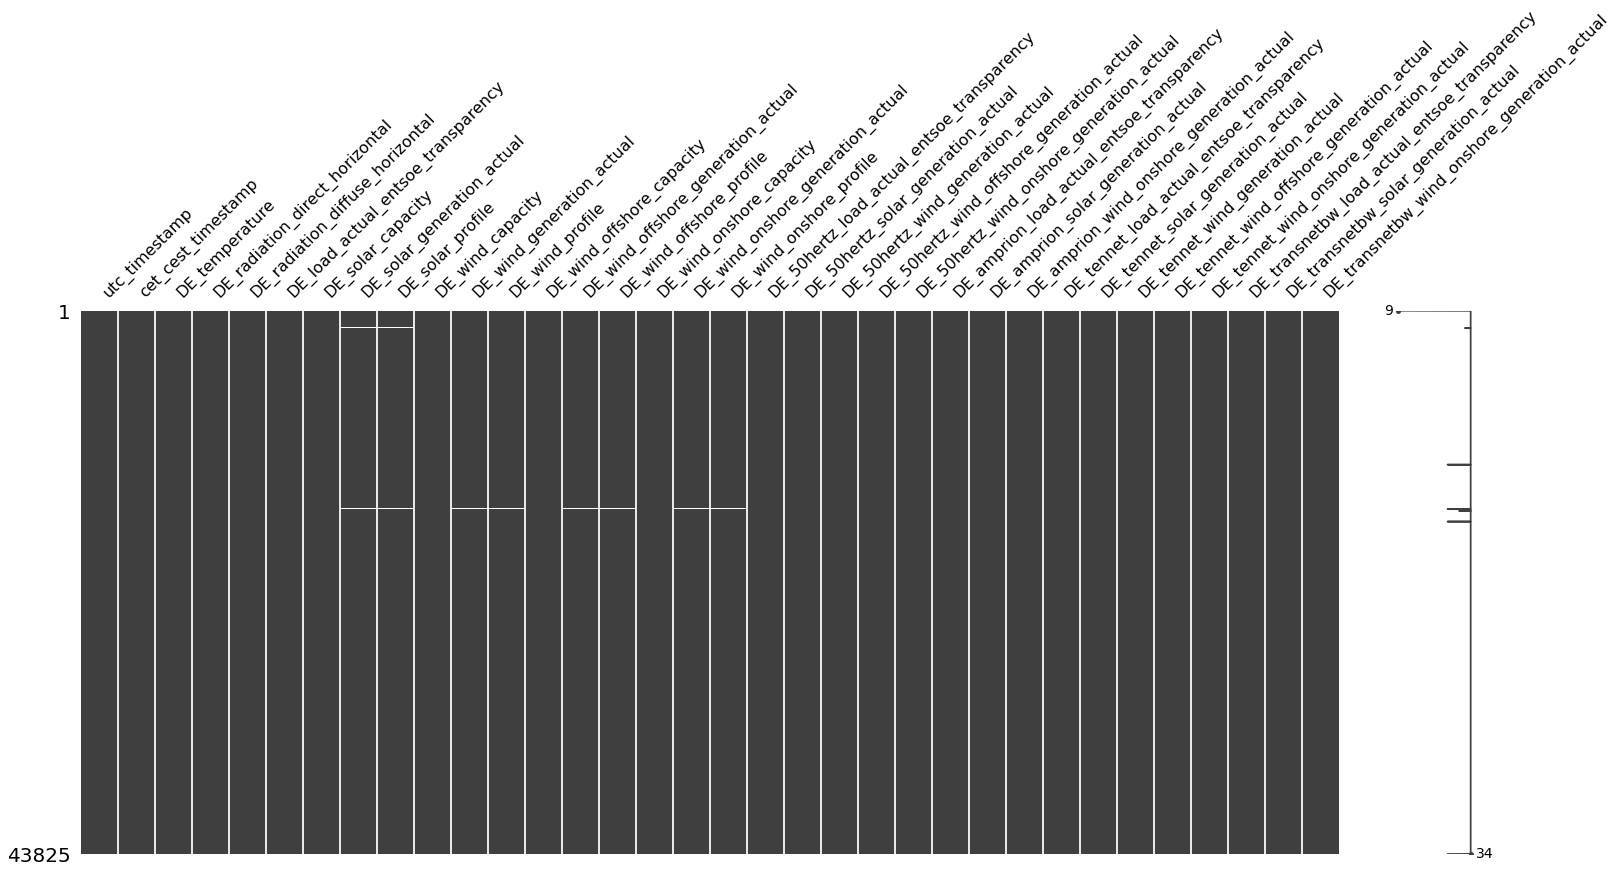

In [10]:
msno.matrix(ts_wt_DE)

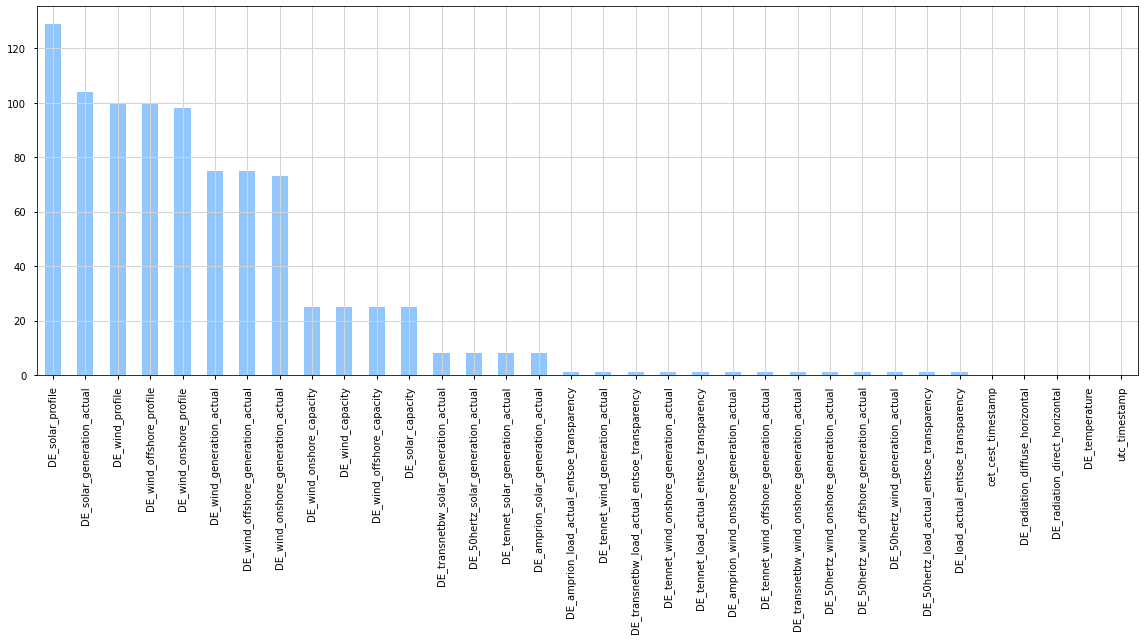

The number of rows having one or more nulls = 131 rows out of 43825 rows


In [11]:
sort_null_col = ts_wt_DE.isna().sum().sort_values(ascending = False)
sort_null_col.plot(kind = 'bar', figsize = (16,9))


plt.show()
print('The number of rows having one or more nulls = %s rows out of %s rows'\
      %(ts_wt_DE.isna().any(axis = 1).sum(), len(ts_wt_DE)))

In [12]:
ts_wt_DE.describe()

DE_temperature  DE_radiation_direct_horizontal  DE_radiation_diffuse_horizontal  DE_load_actual_entsoe_transparency  DE_solar_capacity  DE_solar_generation_actual  DE_solar_profile  DE_wind_capacity  DE_wind_generation_actual  DE_wind_profile  ...  DE_amprion_solar_generation_actual  DE_amprion_wind_onshore_generation_actual  DE_tennet_load_actual_entsoe_transparency  DE_tennet_solar_generation_actual  DE_tennet_wind_generation_actual  DE_tennet_wind_offshore_generation_actual  DE_tennet_wind_onshore_generation_actual  DE_transnetbw_load_actual_entsoe_transparency  DE_transnetbw_solar_generation_actual  DE_transnetbw_wind_onshore_generation_actual
count    43825.000000                    43825.000000                     43825.000000                        43824.000000       43800.000000                43721.000000      43696.000000      43800.000000               43750.000000     43725.000000  ...                        43817.000000                               43824.000000                               43824.000000                       43817.000000                      43824.000000                               43824.000000                              43824.000000                                   43824.000000                           43817.000000                                  43824.000000
mean         9.850472                       82.748991                        67.072165                        55859.295044       42378.015114                 4304.566318          0.101902      39972.606758               11157.555246         0.278908  ...                          998.543670                                1772.858091                               17352.092301                        1597.470069                       5522.850767                                1615.273503                               3907.576100                                    7020.890631                             608.913139                                    231.643232
std          8.130307                      158.997996                        89.173543                        10005.619850        4306.391773                 6603.857970          0.155718       7262.785787                8694.138488         0.211566  ...                         1546.708047                                1727.707418                                3225.317976                        2479.432498                       4180.175337                                1308.519701                               3175.013254                                    1545.703965                             954.399754                                    272.041884
min        -12.686000                        0.000000                         0.000000                        31307.000000       37248.000000                    0.000000          0.000000      27913.000000                 135.000000         0.003800  ...                            0.000000                                   0.000000                               10264.000000                           0.000000                         20.000000                                   0.000000                                  0.000000                                    3516.000000                               0.000000                                      0.000000
25%          3.261000                        0.000000                         0.000000                        47432.000000       38810.000000                    0.000000          0.000000      33737.000000                4422.250000         0.114900  ...                            0.000000                                 504.000000                               14621.000000                           0.000000                       2055.000000                                 441.000000                               1412.000000                                    5696.000000                               0.000000                                     40.000000
50%          9.237000        

In [13]:
sort_null_col

DE_solar_profile                                 129
DE_solar_generation_actual                       104
DE_wind_profile                                  100
DE_wind_offshore_profile                         100
DE_wind_onshore_profile                           98
DE_wind_generation_actual                         75
DE_wind_offshore_generation_actual                75
DE_wind_onshore_generation_actual                 73
DE_wind_onshore_capacity                          25
DE_wind_capacity                                  25
DE_wind_offshore_capacity                         25
DE_solar_capacity                                 25
DE_transnetbw_solar_generation_actual              8
DE_50hertz_solar_generation_actual                 8
DE_tennet_solar_generation_actual                  8
DE_amprion_solar_generation_actual                 8
DE_amprion_load_actual_entsoe_transparency         1
DE_tennet_wind_generation_actual                   1
DE_transnetbw_load_actual_entsoe_transparency 

### duplicates

In [14]:
ts_wt_DE.duplicated# generate count statistics of duplicate entries
if len(ts_wt_DE[ts_wt_DE.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(ts_wt_DE[ts_wt_DE.duplicated()]))
    print(ts_wt_DE[ts_wt_DE.duplicated(keep=False)].sort_values(by=list(ts_wt_DE.columns)).head())
else: 
    print("No duplicated entries found")

No duplicated entries found


## correlation matrix

In [18]:
cols = ts_wt_DE_try.corr().nlargest(20, 'DE_sum4zone_solar_generation_actual')['DE_sum4zone_solar_generation_actual'].index
f, ax = plt.subplots(figsize = (14,14))
sns.heatmap(ts_wt_DE_try[cols].corr(), cmap='RdBu_r', square = True, annot=True)

KeyError: 'DE_sum4zone_solar_generation_actual'

## check homoscedascity

### targets

In [17]:
ts_wt_DE_try = ts_wt_DE.dropna()

In [19]:
targets = [
    'DE_load_actual_entsoe_transparency',
    'DE_solar_capacity',
    'DE_solar_generation_actual',
    'DE_solar_profile'
]

DE_load_actual_entsoe_transparency
Before >  Mean: 55860.220717, SD: 10006.314897


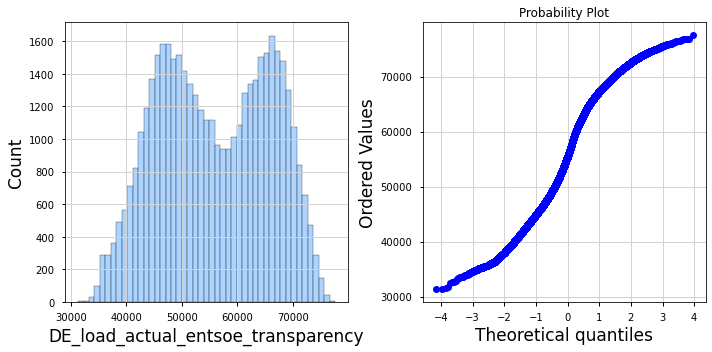

DE_solar_capacity
Before >  Mean: 42386.738912, SD: 4307.660947


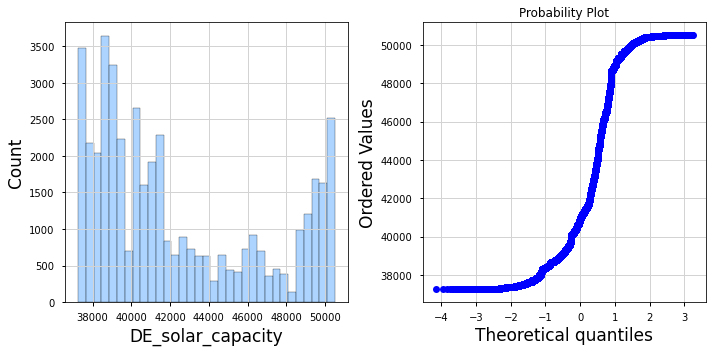

DE_solar_generation_actual
Before >  Mean: 4306.327551, SD: 6605.138255


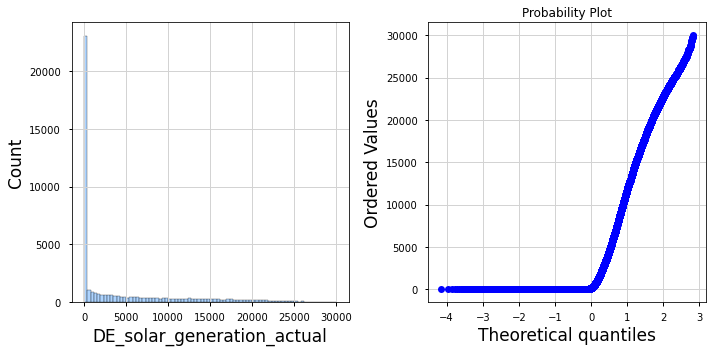

DE_solar_profile
Before >  Mean: 0.101905, SD: 0.155719


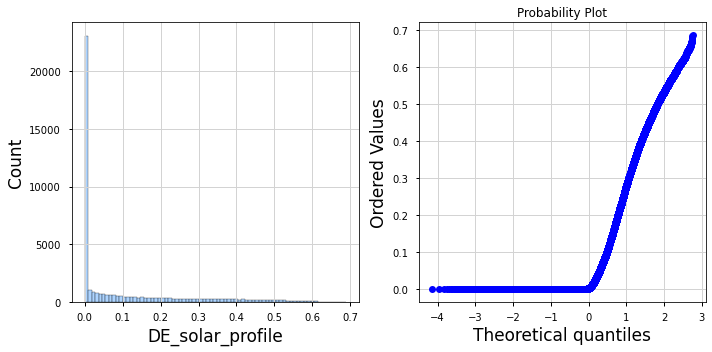

In [20]:
from scipy import stats
from scipy.stats import norm, skew
for target in targets:
    print(target)
    fig, ax= plt.subplots(1,2, figsize = (10,5))
    print("Before >  Mean: %f, SD: %f" %norm.fit(ts_wt_DE_try[target]))
    sns.histplot(ts_wt_DE[target], ax = ax[0])
    stats.probplot(ts_wt_DE[target], plot=ax[1])
    plt.show()

### features

In [21]:
skews = []
for col in ts_wt_DE_try.columns:
    if type(ts_wt_DE_try[col].values[0]) != str:
        skews.append((col, skew(ts_wt_DE_try[col])))   #func เช็คความเบ้ของ stat
skews.sort(key=lambda x : -abs(x[1]))

skews

[('DE_radiation_direct_horizontal', 2.2237939641428226),
 ('DE_transnetbw_wind_onshore_generation_actual', 1.7893417105852896),
 ('DE_50hertz_solar_generation_actual', 1.6609921113958817),
 ('DE_transnetbw_solar_generation_actual', 1.5975548729386455),
 ('DE_tennet_solar_generation_actual', 1.592749403308814),
 ('DE_amprion_solar_generation_actual', 1.5901157523819887),
 ('DE_solar_generation_actual', 1.555320511178618),
 ('DE_50hertz_wind_offshore_generation_actual', 1.5493695325241832),
 ('DE_solar_profile', 1.5300998498025202),
 ('DE_amprion_wind_onshore_generation_actual', 1.4692177008693192),
 ('DE_wind_onshore_generation_actual', 1.2733801853613824),
 ('DE_radiation_diffuse_horizontal', 1.2598435370648737),
 ('DE_wind_onshore_profile', 1.2399325950057971),
 ('DE_50hertz_wind_onshore_generation_actual', 1.2354748569065181),
 ('DE_50hertz_wind_generation_actual', 1.2205885693769798),
 ('DE_wind_generation_actual', 1.1325219582563255),
 ('DE_tennet_wind_onshore_generation_actual', 1

In [22]:
#จัดการเฉพาะตัวที่ corr ต่อ 'DE_solar_generation_actual' สูงๆ
cols = ts_wt_DE_try.corr().nlargest(15, 'DE_solar_generation_actual')['DE_solar_generation_actual'].index

tmp = []
for i in skews:
    if abs(i[1]) > 0 and i[0] in cols:
        tmp.append(i)
tmp

[('DE_radiation_direct_horizontal', 2.2237939641428226),
 ('DE_50hertz_solar_generation_actual', 1.6609921113958817),
 ('DE_transnetbw_solar_generation_actual', 1.5975548729386455),
 ('DE_tennet_solar_generation_actual', 1.592749403308814),
 ('DE_amprion_solar_generation_actual', 1.5901157523819887),
 ('DE_solar_generation_actual', 1.555320511178618),
 ('DE_solar_profile', 1.5300998498025202),
 ('DE_radiation_diffuse_horizontal', 1.2598435370648737),
 ('DE_temperature', 0.23829175094861219),
 ('DE_50hertz_load_actual_entsoe_transparency', -0.2010311403038277),
 ('DE_wind_onshore_capacity', -0.09006430997262636),
 ('DE_transnetbw_load_actual_entsoe_transparency', 0.0531744889943658),
 ('DE_load_actual_entsoe_transparency', -0.033195629980402444),
 ('DE_amprion_load_actual_entsoe_transparency', -0.0241327977250079),
 ('DE_tennet_load_actual_entsoe_transparency', 0.01576057908631397)]

('DE_radiation_direct_horizontal', 2.2237939641428226)
Before >  Mean: 82.934314, SD: 159.173268


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


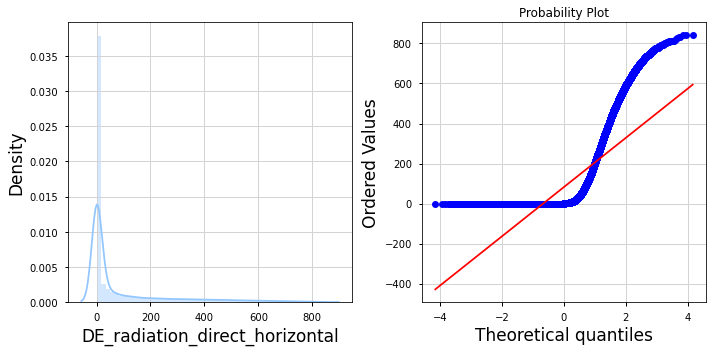

('DE_50hertz_solar_generation_actual', 1.6609921113958817)
Before >  Mean: 1097.572458, SD: 1733.290065


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


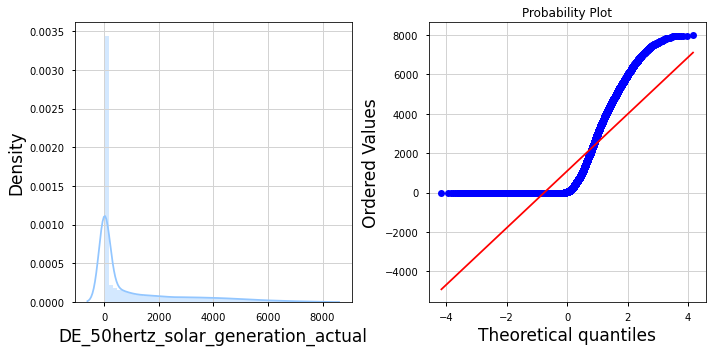

('DE_transnetbw_solar_generation_actual', 1.5975548729386455)
Before >  Mean: 609.373552, SD: 955.014278


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


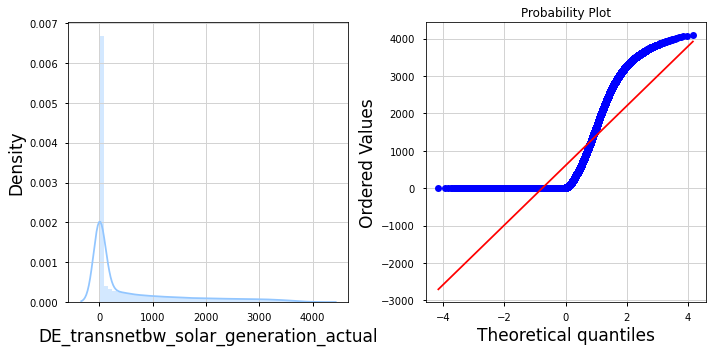

('DE_tennet_solar_generation_actual', 1.592749403308814)
Before >  Mean: 1599.717078, SD: 2481.695429


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


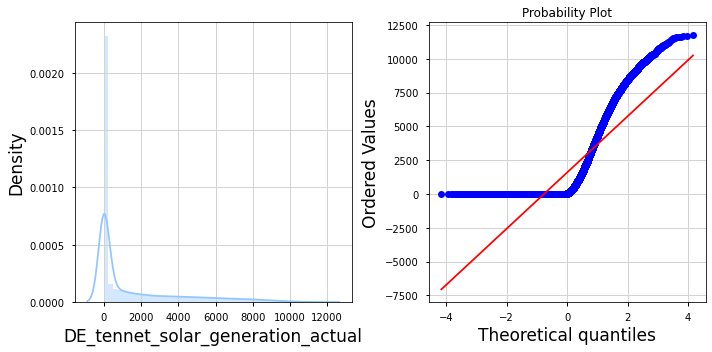

('DE_amprion_solar_generation_actual', 1.5901157523819887)
Before >  Mean: 999.782213, SD: 1547.925330


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


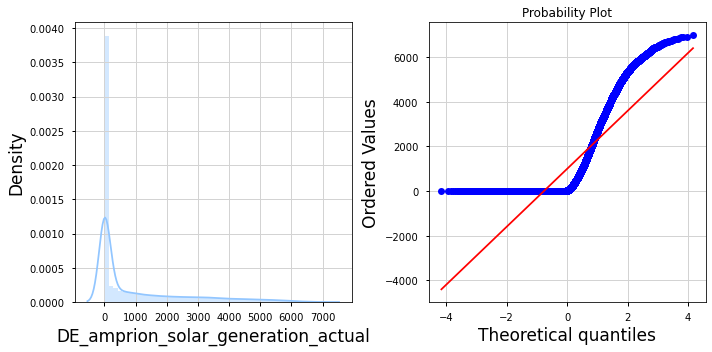

('DE_solar_generation_actual', 1.555320511178618)
Before >  Mean: 4306.327551, SD: 6605.138255


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


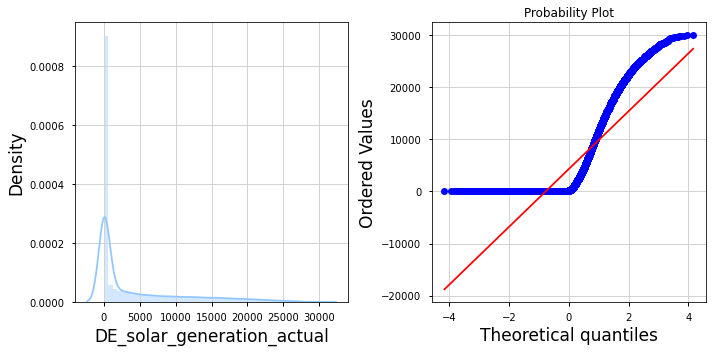

('DE_solar_profile', 1.5300998498025202)
Before >  Mean: 0.101905, SD: 0.155719


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


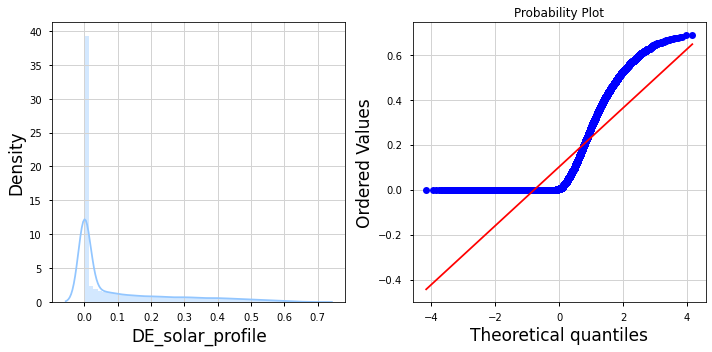

('DE_radiation_diffuse_horizontal', 1.2598435370648737)
Before >  Mean: 67.110716, SD: 89.164676


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


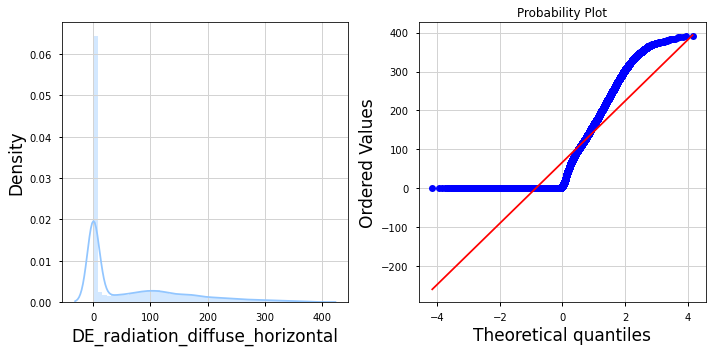

('DE_temperature', 0.23829175094861219)
Before >  Mean: 9.862320, SD: 8.132464


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


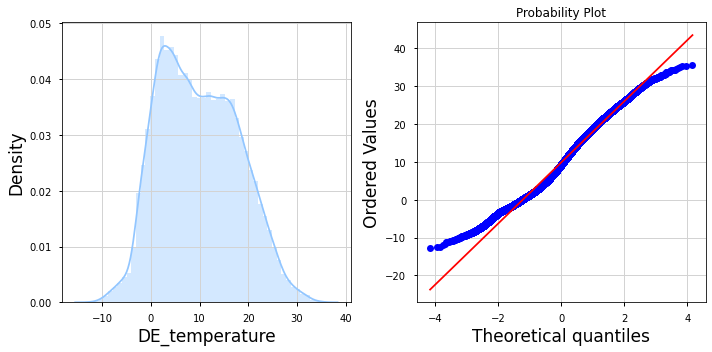

('DE_50hertz_load_actual_entsoe_transparency', -0.2010311403038277)
Before >  Mean: 10370.765025, SD: 1977.761372


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


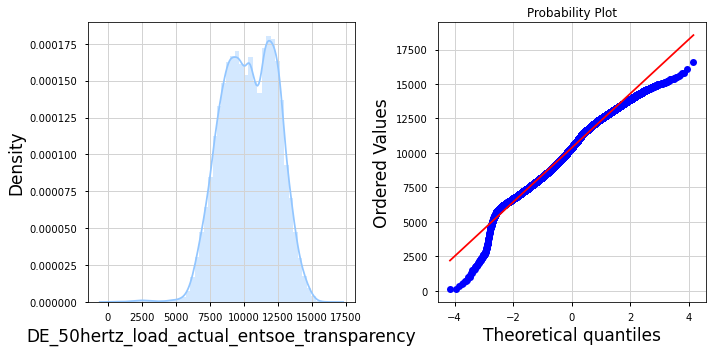

('DE_wind_onshore_capacity', -0.09006430997262636)
Before >  Mean: 36724.367877, SD: 5961.474985


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


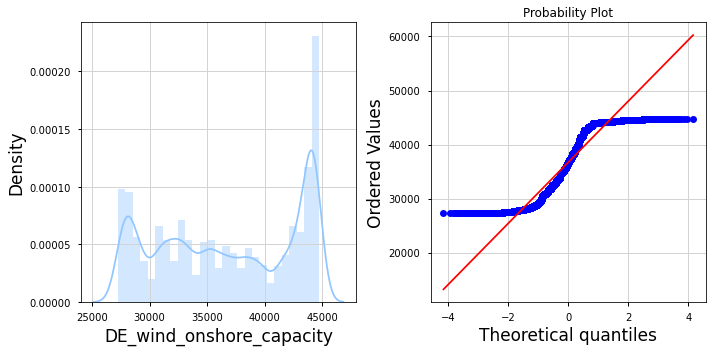

('DE_transnetbw_load_actual_entsoe_transparency', 0.0531744889943658)
Before >  Mean: 7020.745846, SD: 1545.691724


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


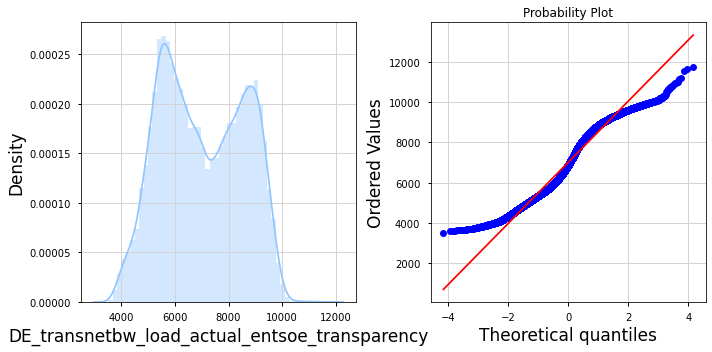

('DE_load_actual_entsoe_transparency', -0.033195629980402444)
Before >  Mean: 55860.220717, SD: 10006.314897


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


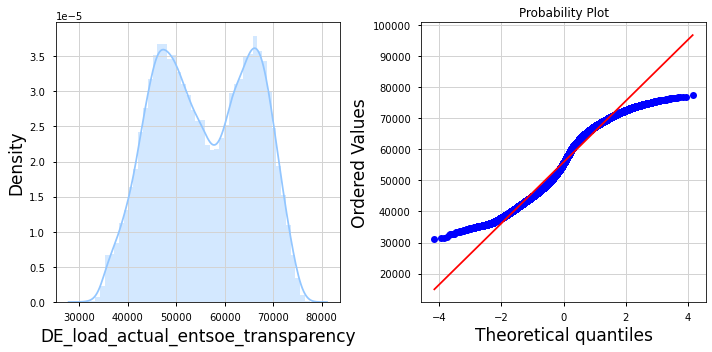

('DE_amprion_load_actual_entsoe_transparency', -0.0241327977250079)
Before >  Mean: 21117.198998, SD: 3579.253470


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


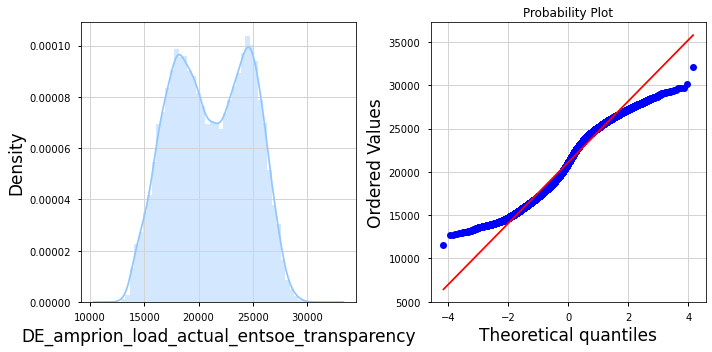

('DE_tennet_load_actual_entsoe_transparency', 0.01576057908631397)
Before >  Mean: 17351.753605, SD: 3225.231919


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


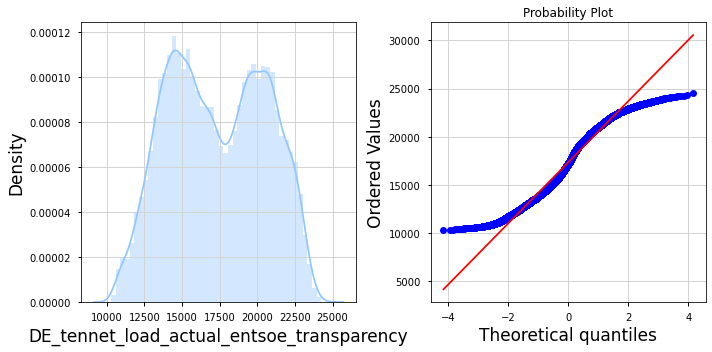

In [23]:
from scipy import stats
from scipy.stats import norm, skew
for i in tmp:
    print(i)
    fig, ax= plt.subplots(1,2, figsize = (10,5))
    print("Before >  Mean: %f, SD: %f" %norm.fit(ts_wt_DE_try[i[0]]))
    sns.distplot(ts_wt_DE_try[i[0]], ax = ax[0])
    stats.probplot(ts_wt_DE_try[i[0]], plot=ax[1])
    plt.show()

##### ต้องบอกให้ได้ว่าถ้ามันเป็นแบบนี้แล้วต้องใช้วิธีอะไรในการทำต่อ

In [24]:
ts_wt_DE_try.corr().nlargest(15, 'DE_solar_generation_actual')['DE_solar_generation_actual'].index

Index(['DE_solar_generation_actual', 'DE_tennet_solar_generation_actual', 'DE_solar_profile', 'DE_amprion_solar_generation_actual', 'DE_50hertz_solar_generation_actual', 'DE_transnetbw_solar_generation_actual', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal', 'DE_temperature', 'DE_amprion_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_wind_onshore_capacity'], dtype='object')

In [25]:
ts_wt_DE_try['DE_sum4zone_solar_generation_actual'] = \
ts_wt_DE_try['DE_tennet_solar_generation_actual'] + \
ts_wt_DE_try['DE_amprion_solar_generation_actual'] + \
ts_wt_DE_try['DE_50hertz_solar_generation_actual'] + \
ts_wt_DE_try['DE_transnetbw_solar_generation_actual']

ts_wt_DE_try.reset_index(inplace = True, drop = True)


C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


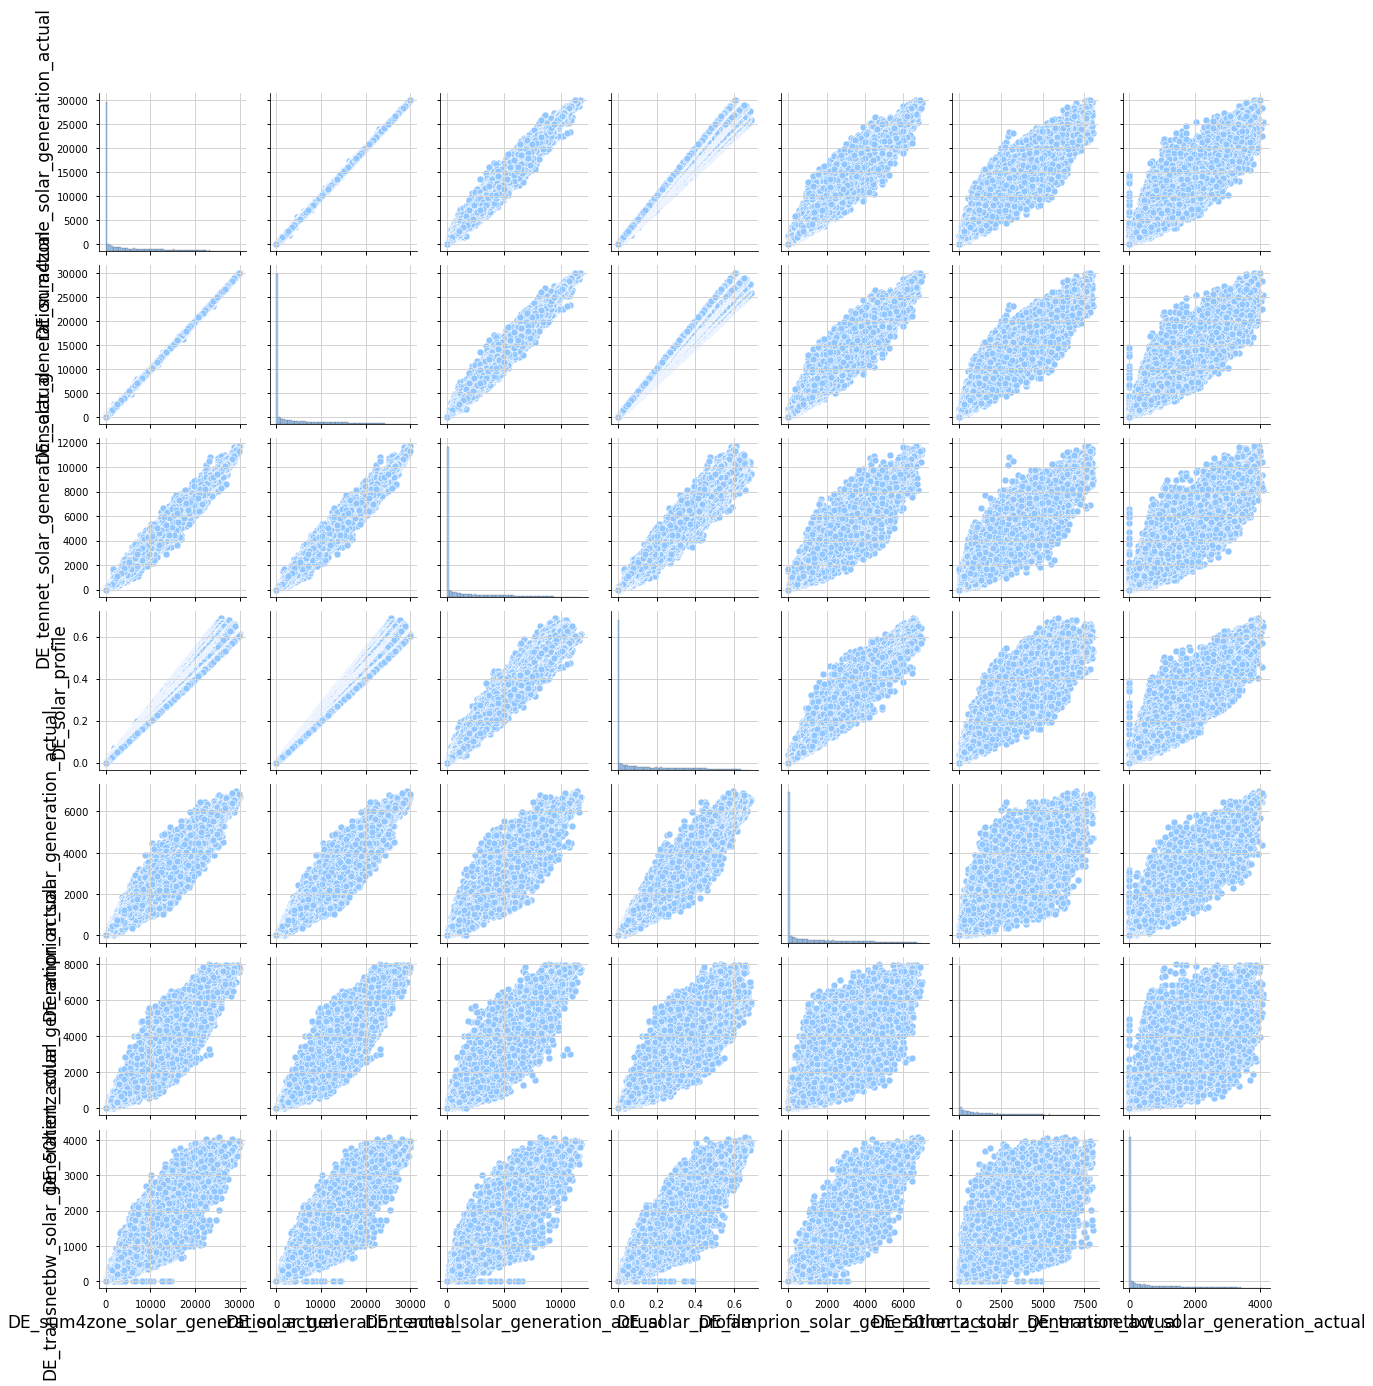

In [26]:
cols = ts_wt_DE_try.corr().nlargest(7, 'DE_sum4zone_solar_generation_actual')['DE_sum4zone_solar_generation_actual'].index
sns.pairplot(ts_wt_DE_try[cols])
plt.show()

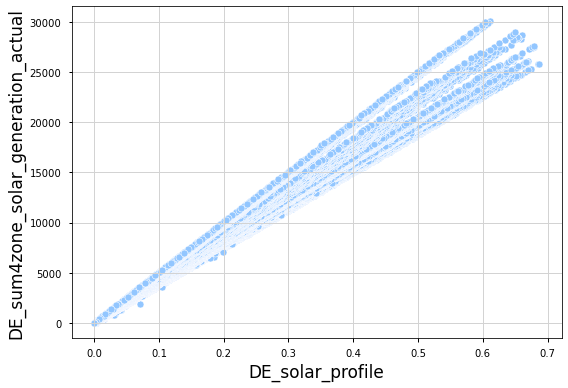

In [27]:
sns.scatterplot(data=ts_wt_DE_try, x='DE_solar_profile', y='DE_sum4zone_solar_generation_actual')         
plt.show()

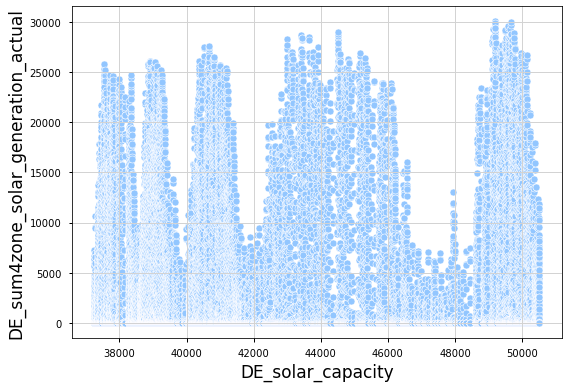

In [29]:
sns.scatterplot(data=ts_wt_DE_try, x='DE_solar_capacity', y='DE_sum4zone_solar_generation_actual')         
plt.show()

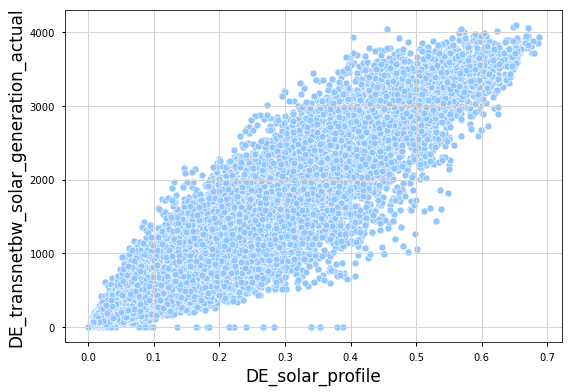

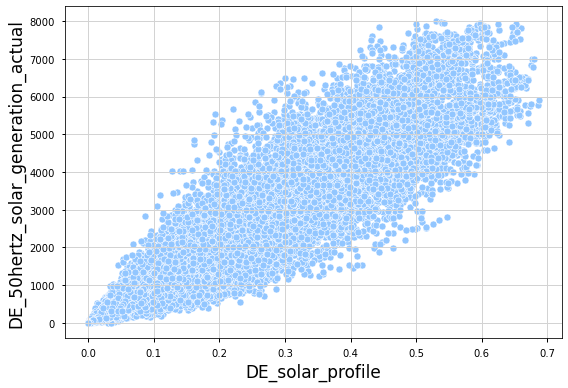

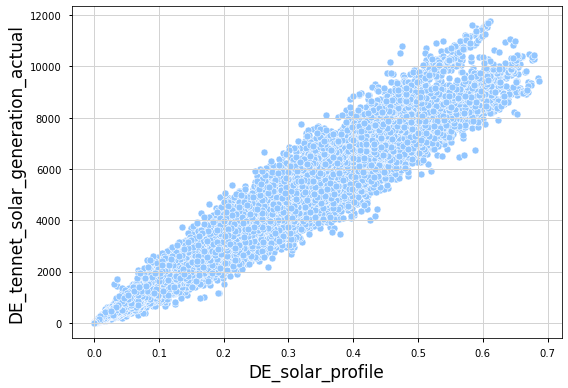

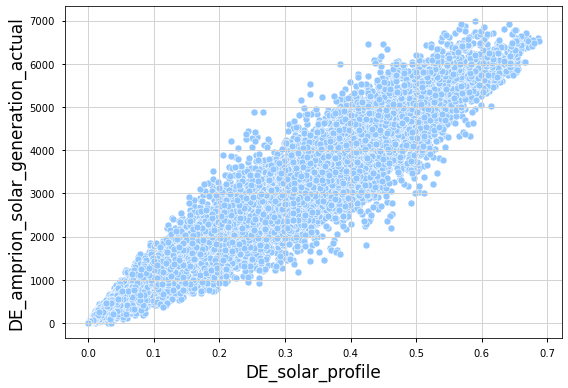

In [30]:
gen_list = [
    'DE_transnetbw_solar_generation_actual',
    'DE_50hertz_solar_generation_actual', 
    'DE_tennet_solar_generation_actual', 
    'DE_amprion_solar_generation_actual'
]

for i in gen_list:
    sns.scatterplot(data=ts_wt_DE_try, x='DE_solar_profile', y= i)         
    plt.show()

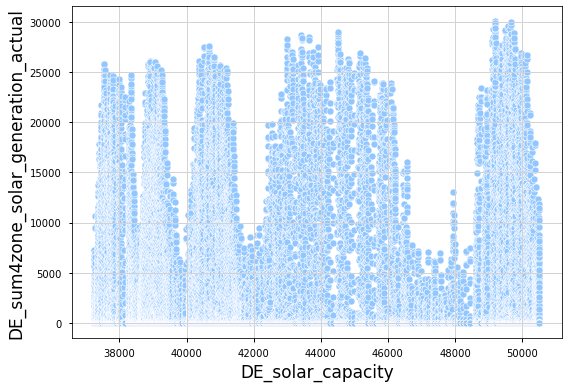

In [31]:
sns.scatterplot(data=ts_wt_DE_try, x='DE_solar_capacity', y='DE_sum4zone_solar_generation_actual')         
plt.show()

In [31]:
for i in ts_wt_DE_try.columns:
    print(i)

utc_timestamp
cet_cest_timestamp
DE_temperature
DE_radiation_direct_horizontal
DE_radiation_diffuse_horizontal
DE_load_actual_entsoe_transparency
DE_solar_capacity
DE_solar_generation_actual
DE_solar_profile
DE_wind_capacity
DE_wind_generation_actual
DE_wind_profile
DE_wind_offshore_capacity
DE_wind_offshore_generation_actual
DE_wind_offshore_profile
DE_wind_onshore_capacity
DE_wind_onshore_generation_actual
DE_wind_onshore_profile
DE_50hertz_load_actual_entsoe_transparency
DE_50hertz_solar_generation_actual
DE_50hertz_wind_generation_actual
DE_50hertz_wind_offshore_generation_actual
DE_50hertz_wind_onshore_generation_actual
DE_amprion_load_actual_entsoe_transparency
DE_amprion_solar_generation_actual
DE_amprion_wind_onshore_generation_actual
DE_tennet_load_actual_entsoe_transparency
DE_tennet_solar_generation_actual
DE_tennet_wind_generation_actual
DE_tennet_wind_offshore_generation_actual
DE_tennet_wind_onshore_generation_actual
DE_transnetbw_load_actual_entsoe_transparency
DE_transn

##### Features that need to be excluded
- ?load
- ?solar profile (explanation: Share of installed capacity producing)
- solar capacity (Aggregated installed capacity of power plants (actual availability not accounted for))
- De_solar_generation_actual -> DE_sum4zone_solar_geeneration_actual (สร้างเอง)
- load ตัดออก
- ?คิดว่าถึงจะมีโอกาสเกี่ยวก็จะต้องตัดออก เพราะมันไม่ใช่ raw data ของ wind

In [32]:
temp = []
for i in ts_wt_DE_try.columns:
    if ('wind' not in i.lower()) and\
    ('load' not in i.lower()) and\
    ('profile' not in i.lower()) and\
    ('capacity' not in i.lower()):
        temp.append(i)
temp.remove('DE_solar_generation_actual')
temp

['utc_timestamp',
 'cet_cest_timestamp',
 'DE_temperature',
 'DE_radiation_direct_horizontal',
 'DE_radiation_diffuse_horizontal',
 'DE_50hertz_solar_generation_actual',
 'DE_amprion_solar_generation_actual',
 'DE_tennet_solar_generation_actual',
 'DE_transnetbw_solar_generation_actual',
 'DE_sum4zone_solar_generation_actual']

In [33]:
ts_wt_DE_try[temp]

utc_timestamp        cet_cest_timestamp  DE_temperature  DE_radiation_direct_horizontal  DE_radiation_diffuse_horizontal  DE_50hertz_solar_generation_actual  DE_amprion_solar_generation_actual  DE_tennet_solar_generation_actual  DE_transnetbw_solar_generation_actual  DE_sum4zone_solar_generation_actual
0      2015-01-01T07:00:00Z  2015-01-01T08:00:00+0100          -1.692                          0.4328                           6.7680                                52.0                                14.0                               15.0                                    8.0                                 89.0
1      2015-01-01T08:00:00Z  2015-01-01T09:00:00+0100          -1.046                          8.8773                          51.9464                               267.0                               272.0                              175.0                                   60.0                                774.0
2      2015-01-01T09:00:00Z  2015-01-01T10:00:00+0100           0.072                         34.1583                          97.0929                               804.0                               773.0                              426.0                                  113.0                               2116.0
3      2015-01-01T10:00:00Z  2015-01-01T11:00:00+0100           0.866                         56.5458                         120.2907                              1512.0                              1057.0                              658.0                                  137.0                               3364.0
4      2015-01-01T11:00:00Z  2015-01-01T12:00:00+0100           1.493                         62.8690                         126.2112                              1892.0                              1379.0                              762.0                                  166.0                               4199.0
...                     ...                       ...             ...                             ...                              ...                                 ...                                 ...                                ...                                    ...                                  ...
43689  2019-12-30T18:00:00Z  2019-12-30T19:00:00+0100           0.225                          0.0000                           0.0000                                 0.0                                 0.0                                0.0                                    0.0                                  0.0
43690  2019-12-30T19:00:00Z  2019-12-30T20:00:00+0100           0.025                          0.0000                           0.0000                                 0.0                                 0.0                                0.0                                    0.0                                  0.0
43691  2019-12-30T20:00:00Z  2019-12-30T21:00:00+0100          -0.148                          0.0000                           0.0000                                 0.0                                 0.0                                0.0                                    0.0                                  0.0
43692  2019-12-30T21:00:00Z  2019-12-30T22:00:00+0100          -0.243                          0.0000                           0.0000                                 0.0                                 0.0                                0.0                                    0.0                                  0.0
43693  2019-12-30T22:00:00Z  2019-12-30T23:00:00+0100          -0.251                          0.0000                           0.0000                                 0.0                                 0.0                                0.0                                    0.0                                  0.0

[43694 rows x 10 columns]

# Weather

In [34]:
ts_wt_DE_try[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']].corr()

DE_temperature  DE_radiation_direct_horizontal  DE_radiation_diffuse_horizontal
DE_temperature                         1.000000                        0.528209                         0.473472
DE_radiation_direct_horizontal         0.528209                        1.000000                         0.537800
DE_radiation_diffuse_horizontal        0.473472                        0.537800                         1.000000

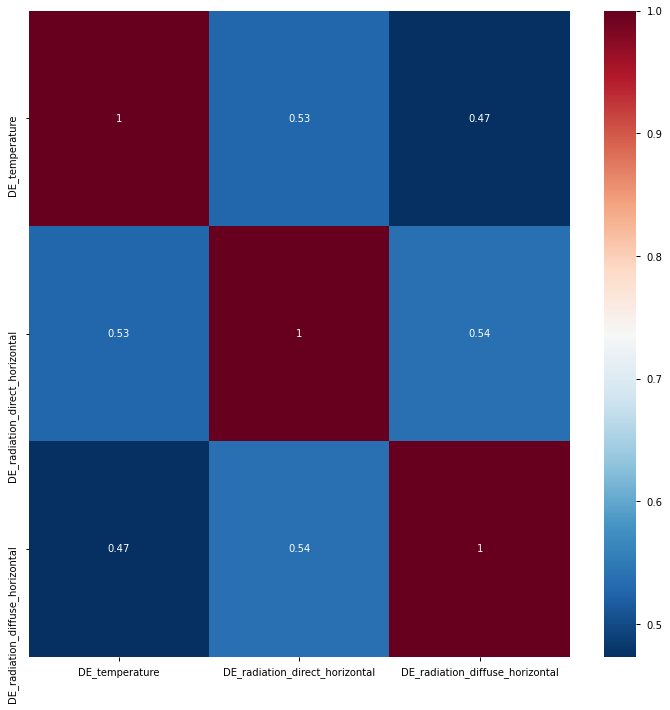

In [35]:
plt.subplots(figsize=(10, 10))
sns.heatmap(ts_wt_DE_try[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']].corr(), xticklabels=ts_wt_DE[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']].columns, yticklabels=ts_wt_DE[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']].columns, cmap='RdBu_r', annot=True)
plt.show()

In [36]:
#change format utc_datetime to datetime
ts_wt_DE_try['utc_timestamp'] = \
ts_wt_DE_try['utc_timestamp'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Columns plots

In [37]:
for year in range(2015,2020):
    for i in range(3,15,3):
        print(i, (i+1)%12+1)

3 5
6 8
9 11
12 2
3 5
6 8
9 11
12 2
3 5
6 8
9 11
12 2
3 5
6 8
9 11
12 2
3 5
6 8
9 11
12 2


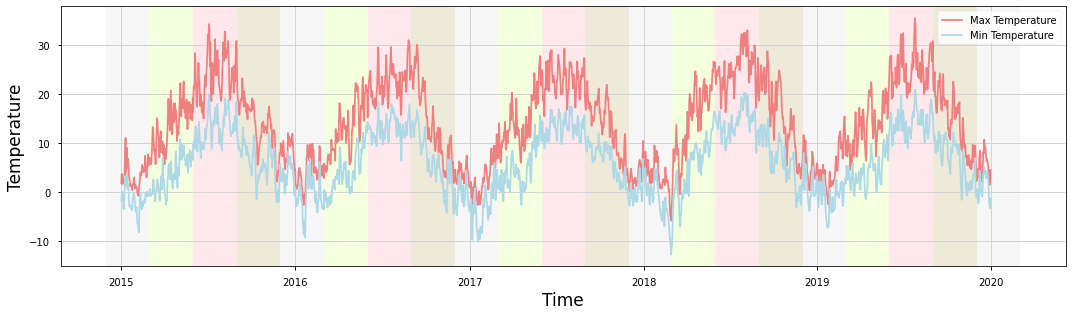

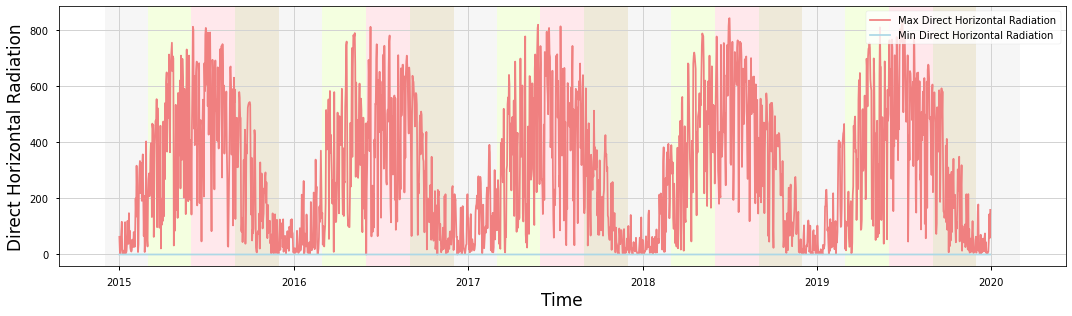

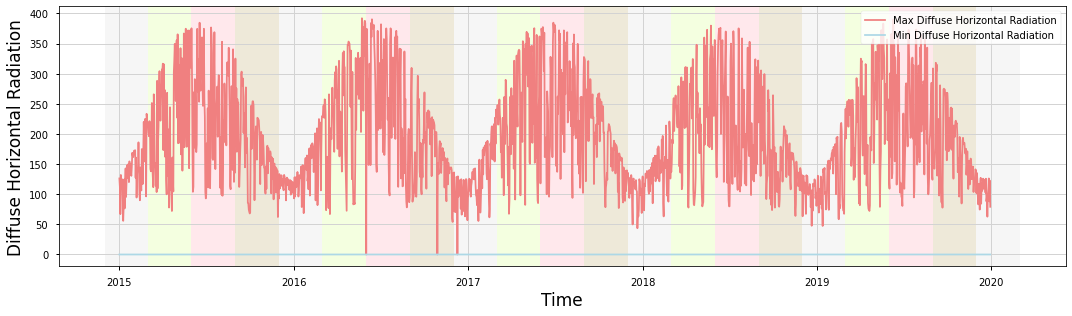

In [38]:
name_list = ['Temperature', 'Direct Horizontal Radiation', 'Diffuse Horizontal Radiation']
for i, name in zip(ts_wt_DE[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']].columns, name_list):
    ts_wt_DE_try.groupby(
        ts_wt_DE_try['utc_timestamp'].dt.date
    ).agg(
        'max'
    )[i].plot(
        ylabel = name, 
        c = 'lightcoral',
        figsize = (15,4.5),
        label = 'Max %s'%name
    )
    
    ts_wt_DE_try.groupby(
        ts_wt_DE_try['utc_timestamp'].dt.date
    ).agg(
        'min'
    )[i].plot(
        ylabel = name, 
        c = 'lightblue',
        alpha = 1,
        label = 'Min %s'%name
    )
    
    for year in range(2015,2020):
        plt.axvspan(dt.date(year,3,1), dt.date(year,6,1), facecolor = '#ccff66', alpha = 0.2)
        plt.axvspan(dt.date(year,6,1), dt.date(year,9,1) , facecolor = '#ff6680', alpha = 0.15)
        plt.axvspan(dt.date(year,9,1), dt.date(year,12,1), facecolor = '#ded5b4', alpha = 0.5)
        plt.axvspan(dt.date(year,12,1), dt.date(year+1,3,1), facecolor = 'lightgrey', alpha = 0.2)
    plt.axvspan(dt.date(2014,12,1), dt.date(2014+1,3,1), facecolor = 'lightgrey', alpha = 0.2)
    
    
#     ts_wt_DE_try.groupby(
#         ts_wt_DE_try['utc_timestamp'].dt.date
#     ).agg(
#         'max'
#     )[i]\
#     .plot(
#         ylabel = i, c = 'red',
#         alpha = 0.2
#     )

    plt.xlabel('Time')
    plt.legend(loc = 1)

    plt.show()

In [40]:
# name_list = ['Temperature (°C)', 'Direct Horizontal Radiation (W/m$^2$)', 'Diffuse Horizontal Radiation (W/m$^2$)']
# for i, name in zip(ts_wt_DE[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']].columns, name_list):
#     ts_wt_DE_try.loc[ts_wt_DE_try['DE_radiation_direct_horizontal'] != 0]\
#     .groupby(
#         ts_wt_DE_try['utc_timestamp'].dt.date
#     ).agg(
#         'mean'
#     )[i]\
#     .plot(
#         ylabel = name, 
#         c = 'royalblue',
#         figsize = (15,4.5)
#     )

    
# #     ts_wt_DE_try.groupby(
# #         ts_wt_DE_try['utc_timestamp'].dt.date
# #     ).agg(
# #         'max'
# #     )[i]\
# #     .plot(
# #         ylabel = i, c = 'red',
# #         alpha = 0.2
# #     )
    
#     plt.ylabel(name, labelpad = 20)
#     plt.xlabel('Time', labelpad = 20)

#     plt.show()

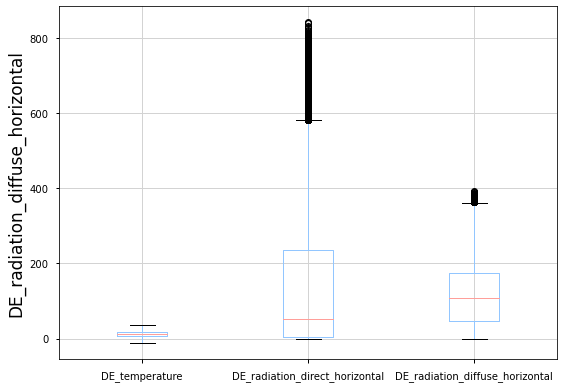

In [118]:
ts_wt_DE[['DE_temperature',
          'DE_radiation_direct_horizontal', 
          'DE_radiation_diffuse_horizontal']].loc[
    ts_wt_DE['DE_radiation_direct_horizontal'] != 0
].plot(
        ylabel = i,
        kind = 'box'
    )
    
plt.show()

# Plot of Radiation in 1 day

## create season column from utc time

In [41]:
def month_to_season(m):
    if m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    elif m in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [42]:
ts_wt_DE_try['season'] = ts_wt_DE_try['utc_timestamp'].dt.month\
.apply(lambda x: month_to_season(x))

C:\Users\nSamsow\Anaconda3\envs\dsprac\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


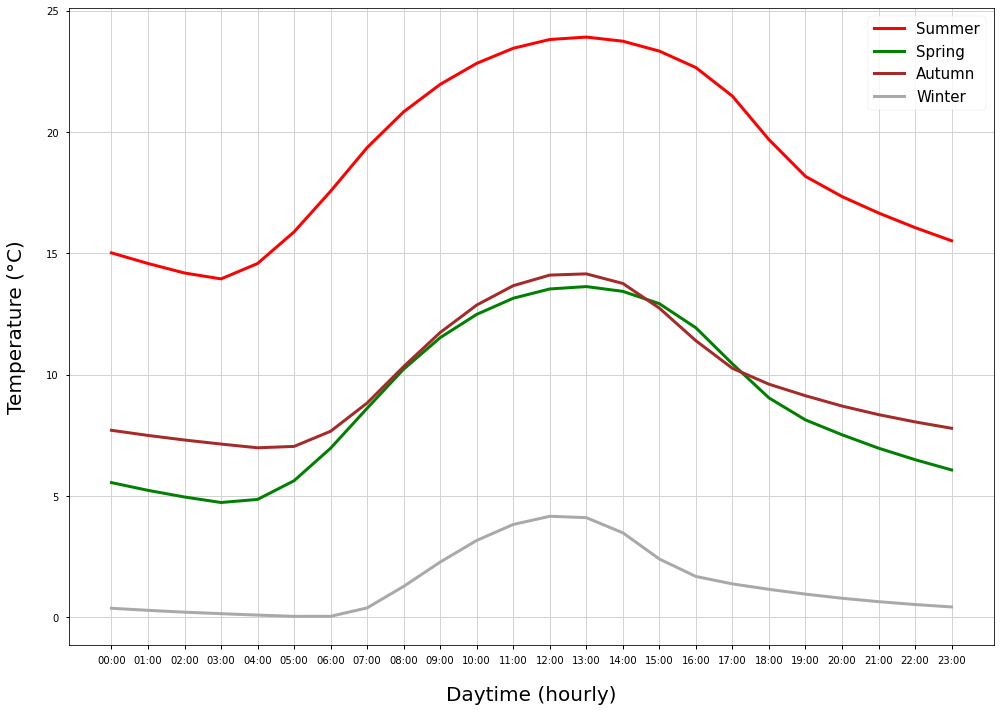

In [43]:
plt.figure(figsize = (14, 10))

ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Summer']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_temperature'].agg('mean').plot(
    xlabel = 'DE_temperature', 
    c ='red',
    linewidth = 3
)


ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_temperature'].agg('mean').plot(
    xlabel = 'DE_temperature', 
    c ='green',
    linewidth = 3
)



ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Autumn']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_temperature'].agg('mean').plot(
    xlabel = 'DE_temperature', 
    c ='brown',
    linewidth = 3
)

ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Winter']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_temperature'].agg('mean').plot(
    xlabel = 'DE_temperature', 
    c ='darkgrey',
    linewidth = 3
)

plt.legend(['Summer', 'Spring', 'Autumn', 'Winter'],fontsize = 15)
plt.xticks(ts_wt_DE_try['utc_timestamp'].dt.time.unique())

plt.xlabel('Daytime (hourly)', labelpad = 20, fontsize = 20)
plt.ylabel('Temperature (°C)', labelpad = 20, fontsize = 20)
plt.show()

In [283]:
plt.legend?

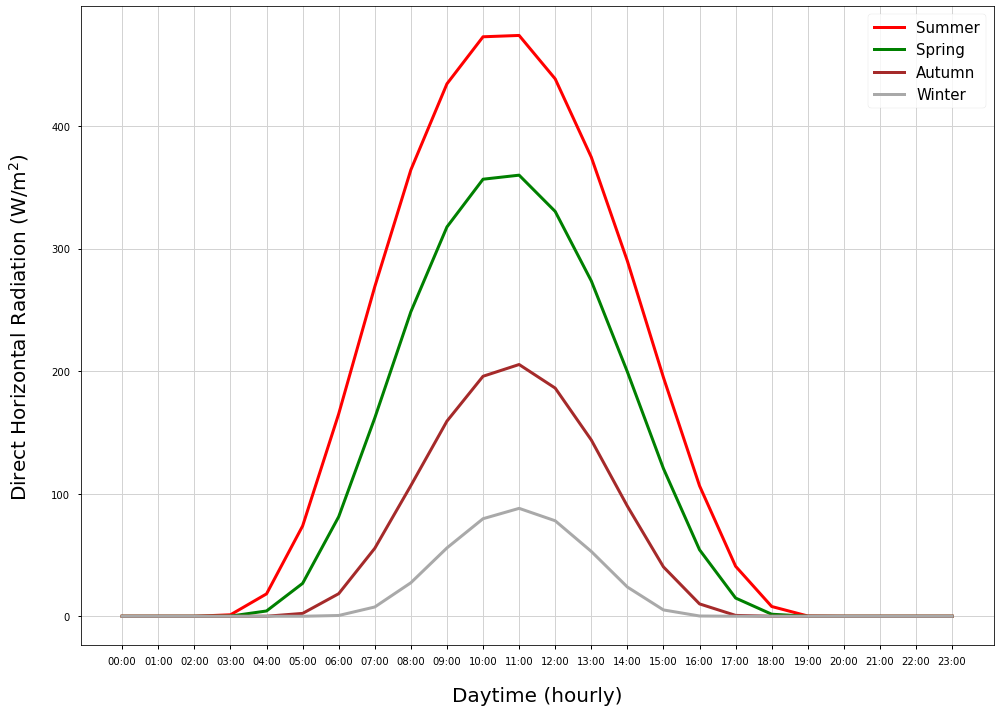

In [44]:
plt.figure(figsize = (14, 10))


ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Summer']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_direct_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_direct_horizontal', 
    c ='red',
    linewidth = 3,
    label = 'Summer'
)
# ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Summer']\
# .groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
# ['DE_radiation_direct_horizontal'].agg('max').plot(
#     xlabel = 'DE_radiation_direct_horizontal', 
#     c ='red',
#     linewidth = 3,
#     alpha = 0.2,
#     label='_nolegend_'
# )







ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_direct_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_direct_horizontal', 
    c ='green',
    linewidth = 3,
    label = 'Spring'
)
# ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring']\
# .groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
# ['DE_radiation_direct_horizontal'].agg('max').plot(
#     xlabel = 'DE_radiation_direct_horizontal', 
#     c ='green',
#     linewidth = 3,
#     alpha = 0.2,
#     label='_nolegend_'
# )










ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Autumn']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_direct_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_direct_horizontal', 
    c ='brown',
    linewidth = 3,
    label = 'Autumn'
)
# ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Autumn']\
# .groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
# ['DE_radiation_direct_horizontal'].agg('max').plot(
#     xlabel = 'DE_radiation_direct_horizontal', 
#     c ='brown',
#     linewidth = 3,
#     alpha = 0.2,
#     label='_nolegend_'
# )




ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Winter']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_direct_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_direct_horizontal', 
    c ='darkgrey',
    linewidth = 3,
    label = 'Winter'
)
# ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Winter']\
# .groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
# ['DE_radiation_direct_horizontal'].agg('max').plot(
#     xlabel = 'DE_radiation_direct_horizontal', 
#     c ='darkgrey',
#     linewidth = 3,
#     alpha = 0.2,
#     label = None
# )



plt.legend(fontsize = 15)
plt.xticks(ts_wt_DE_try['utc_timestamp'].dt.time.unique())

plt.xlabel('Daytime (hourly)', labelpad = 20, fontsize = 20)
plt.ylabel('Direct Horizontal Radiation (W/m$^2$)', labelpad = 20, fontsize = 20)
plt.show()

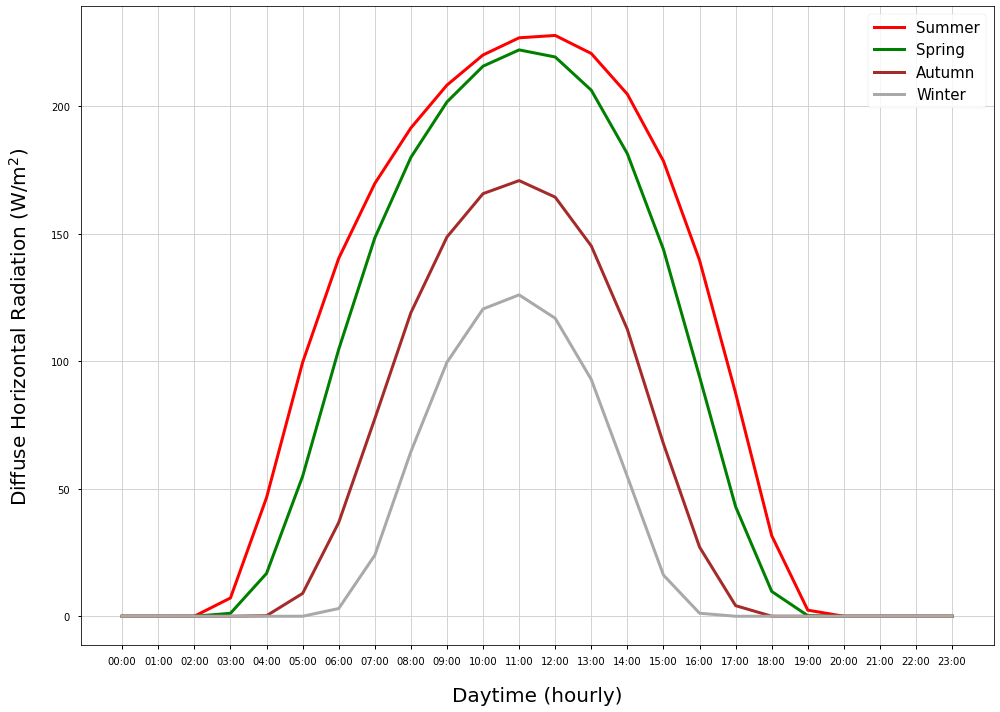

In [45]:
plt.figure(figsize = (14, 10))

ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Summer']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_diffuse_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_diffuse_horizontal', 
    c ='red',
    linewidth = 3
)


ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_diffuse_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_diffuse_horizontal', 
    c ='green',
    linewidth = 3
)


ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Autumn']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_diffuse_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_diffuse_horizontal', 
    c ='brown',
    linewidth = 3
)

ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Winter']\
.groupby(ts_wt_DE_try['utc_timestamp'].dt.time)\
['DE_radiation_diffuse_horizontal'].agg('mean').plot(
    xlabel = 'DE_radiation_diffuse_horizontal', 
    c ='darkgrey',
    linewidth = 3
)

plt.legend(['Summer', 'Spring', 'Autumn', 'Winter'], fontsize = 15)
plt.xticks(ts_wt_DE_try['utc_timestamp'].dt.time.unique())

plt.xlabel('Daytime (hourly)', labelpad = 20, fontsize = 20)
plt.ylabel('Diffuse Horizontal Radiation (W/m$^2$)', labelpad = 20, fontsize = 20)
plt.show()

### Multivariate - Weather vs. Solar Profile

In [79]:
xs = ['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']
xlabels = ['Temperature (°C)', 'Direct Horizontal Radiation (W/m$^2$)', 'Diffuse Horizontal Radiation (W/m$^2$)']
y='DE_solar_profile'
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
sharey = True
sharex = True
figsize = (16,4)

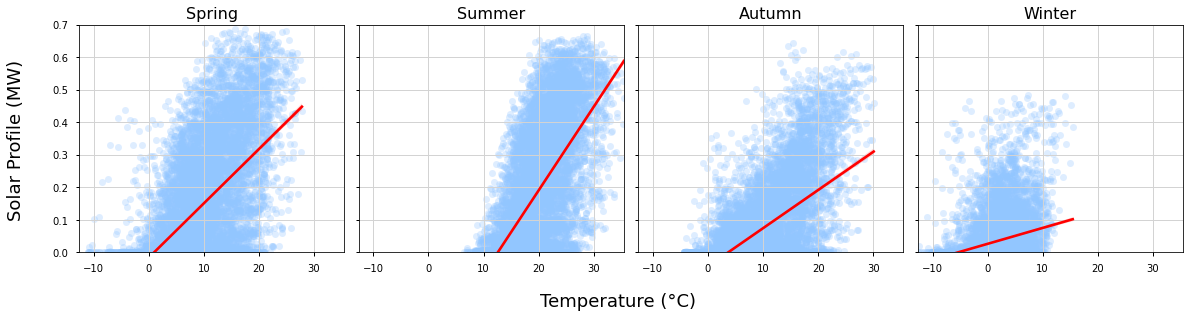

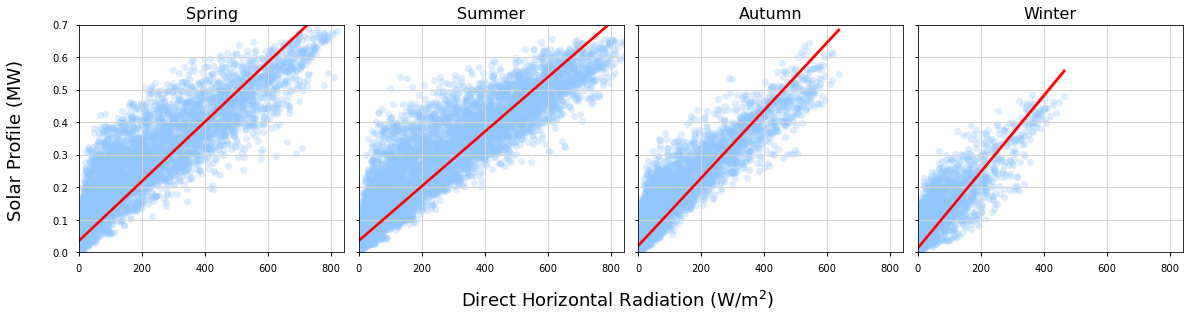

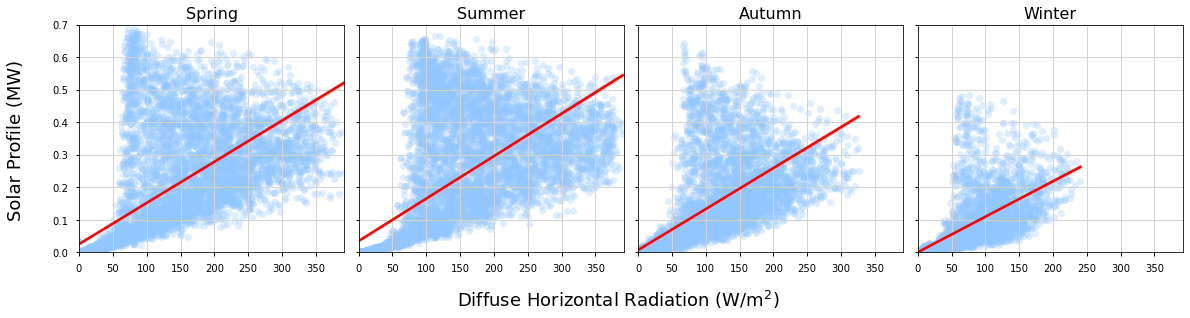

In [80]:
for i, x in enumerate(xs):
    fig, axes = plt.subplots(ncols=len(seasons), sharey=sharey, sharex=sharex, figsize=figsize)
    for j, season in enumerate(seasons):
        axes[j].set_title(season, fontsize = 16)
        sns.regplot(
            data=ts_wt_DE_try.loc[ts_wt_DE_try['season'] == season], x=x, y=y, ax=axes[j],
            line_kws = {'color' : 'red'}, scatter_kws = {'alpha':0.3},
        ).set(ylim = (0,0.7), xlabel = None, ylabel = None)
    fig.text(0.5, -0.08, xlabels[i], ha='center', fontsize = 18)
    fig.text(-0.03, 0.5, 'Solar Profile (MW)', va='center', rotation='vertical', fontsize = 18)
    plt.show()

---

In [74]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=figsize)
# axes = [ax1, ax2, ax3, ax4]
# for idx, season in enumerate(seasons):
#     axes[idx].set_title(season, fontsize = 16)
#     sns.regplot(
#         data=ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring'], 
#         x='DE_radiation_direct_horizontal', 
#         y='DE_solar_profile',
#         line_kws = {'color' : 'red'}, 
#         ax=axes[idx],
#         scatter_kws = {'alpha':0.3},
#     ).set(ylim = (0,0.7), xlabel = None, ylabel = None)
# fig.text(0.5, -0.08, 'Direct Horizontal Radiation (W/m$^2$)', ha='center', fontsize = 18)
# fig.text(-0.03, 0.5, 'Solar Profile', va='center', rotation='vertical', fontsize = 18)
# plt.show()

In [73]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=figsize)
# axes = [ax1, ax2, ax3, ax4]
# for idx, season in enumerate(seasons):
#     axes[idx].set_title(season, fontsize = 16)
#     sns.regplot(
#         data=ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring'], 
#         x='DE_radiation_diffuse_horizontal', 
#         y='DE_solar_profile',
#         line_kws = {'color' : 'red'}, 
#         ax=axes[idx],
#         scatter_kws = {'alpha':0.3},
#     ).set(ylim = (0,0.7), xlabel = None, ylabel = None)   
# fig.text(0.5, -0.08, 'Diffuse Horizontal Radiation (W/m$^2$)', ha='center', fontsize = 18)
# fig.text(-0.03, 0.5, 'Solar Profile', va='center', rotation='vertical', fontsize = 18)
# plt.show()

---

In [60]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, sharex = True, figsize = (16, 5))
# axes = [ax1, ax2, ax3, ax4]
# for idx, season in enumerate(['Spring', 'Summer', 'Autumn', 'Winter']):
#     axes[idx].set_title(season, fontsize = 16)
#     sns.regplot(
#         data=ts_wt_DE_try.loc[ts_wt_DE_try['season'] == season], 
#         x='DE_temperature', 
#         y='DE_sum4zone_solar_generation_actual',
#         line_kws = {'color' : 'red'}, 
#         ax=axes[idx],
#         scatter_kws = {'alpha':0.3},
#     ).set(ylim = (0,31000), xlabel = None, ylabel = None) 
# fig.text(0.5, -0.08, 'Temperature (°C)', ha='center', fontsize = 18)
# fig.text(-0.03, 0.5, 'Total Solar Generation (MW)', va='center', rotation='vertical', fontsize = 18)
# plt.show()

In [61]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, sharex = True, figsize = (16, 5))
# axes = [ax1, ax2, ax3, ax4]
# for idx, season in enumerate(['Spring', 'Summer', 'Autumn', 'Winter']):
#     axes[idx].set_title(season, fontsize = 16)
#     sns.regplot(
#         data=ts_wt_DE_try.loc[ts_wt_DE_try['season'] == 'Spring'], 
#         x='DE_radiation_direct_horizontal', 
#         y='DE_sum4zone_solar_generation_actual',
#         line_kws = {'color' : 'red'}, 
#         ax=axes[idx],
#         scatter_kws = {'alpha':0.3},
#     ).set(ylim = (0,31000), xlabel = None, ylabel = None)             
# fig.text(0.5, -0.08, 'Direct Horizontal Radiation (W/m$^2$)', ha='center', fontsize = 18)
# fig.text(-0.03, 0.5, 'Total Solar Generation (MW)', va='center', rotation='vertical', fontsize = 18)
# plt.show()

---